In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sksurv.util import Surv 
from sksurv.tree import SurvivalTree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge, LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sksurv.ensemble import ExtraSurvivalTrees, RandomSurvivalForest
from sksurv.util import Surv
from lightgbm import LGBMRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.svm import NaiveSurvivalSVM, FastKernelSurvivalSVM, FastSurvivalSVM

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


### Functions

In [2]:
import tsfel
import warnings
import datetime 
from datetime import datetime
import io 
from tabulate import tabulate

# Filter all warnings
warnings.filterwarnings("ignore")

def create_dataframe(num_lags, numbers, real_value, extreme_event, start, stop, duration):
    """
    Create a pandas DataFrame with lag columns and additional metadata.

    Parameters:
    - num_lags (int): Number of lag columns to create.
    - numbers (list): List of numerical values from which lag columns are derived.
    - real_value (list): List of real values to be included in the DataFrame.
    - extreme_event (list): List of extreme event indicators to be included.
    - start (list): List of start dates to be included.
    - stop (list): List of stop dates to be included.
    - duration (list): List of durations to be included.

    Returns:
    - df_new (pandas.DataFrame): A DataFrame containing lag columns, real_value,
      extreme_event, start_date, stop_date, and duration.

    Example Usage:
    num_lags = 3
    numbers = [10, 20, 30, 40, 50]
    real_value = [0.5, 0.6, 0.7, 0.8, 0.9]
    extreme_event = [False, False, True, True, False]
    start = ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']
    stop = ['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06']
    duration = [2, 2, 2, 2, 2]
    df = create_dataframe(num_lags, numbers, real_value, extreme_event, start, stop, duration)
    """
    # Initialize a dictionary to store the lag columns
    lag_columns = {}

    # Create lag columns in the dictionary
    for lag in range(1, num_lags + 1):
        lag_columns[f'lag_{lag}'] = [arr[lag - 1] for arr in numbers]

    # Add other columns to the dictionary
    lag_columns['real_value'] = real_value
    lag_columns['extreme_event'] = extreme_event
    lag_columns['start_date'] = start
    lag_columns['stop_date'] = stop
    lag_columns['duration'] = duration

    # Convert the dictionary to a dataframe
    df_new = pd.DataFrame(lag_columns)

    return df_new

# the old name of this function was -> country_dataframe_cr
def duration_calculation(window_size, df, columns):
    """
    Calculate event durations and create a DataFrame with lag columns and additional metadata.

    Parameters:
    - window_size (int): Size of the time window for calculations.
    - df (pandas.DataFrame): DataFrame containing time series data.
    - columns (list): List of column names, where columns[0] corresponds to the time series data,
      and columns[1] corresponds to the event indicator.

    Returns:
    - df_new (pandas.DataFrame): A DataFrame containing lag columns, real_value,
      extreme_event, start_date, stop_date, and duration.

    Example Usage:
    window_size = 5
    data = pd.DataFrame({'Timestamp': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05'],
                          'Value': [10, 20, 30, 40, 50],
                          'Event': [0, 0, 1, 1, 0]})
    columns = ['Value', 'Event']
    df = duration_calculation(window_size, data, columns)
    """
    #ts = df[df['country']==country]

    ts = df[columns].squeeze()
    print(ts)

    # Define the window size and the number of output steps
    output_steps = 1

    # Create input-output pairs from the time series using a sliding window
    numbers = []
    real_value = []
    extreme_event = []
    duration = []
    start = []
    stop = []

    print(ts.index[0])  
    print(type(print(ts.index[0])  ))
    start_date = ts.index[0]

    for i in range(len(ts)-window_size):
        
        numbers.append(ts[columns[0]][i:i+window_size].values)
        real_value.append(ts.iloc[i+window_size+output_steps-1][columns[0]])
        extreme_event.append(ts.iloc[i+window_size+output_steps-1][columns[1]])

        stop_date = ts.index[i+window_size+output_steps-1] 

        if ts.iloc[i+window_size+output_steps-1][columns[1]] == 1:
          
          # Calculate the duration of the event
          duration.append((stop_date - start_date).days)

          #change the start date 
          start_date = ts.index[i+window_size+output_steps-1]

        else: 
          # Calculate the duration of the event
          duration.append((stop_date - start_date).days)

        # Extract the start and stop date of the time window
        start.append(start_date)
        stop.append(stop_date)
        

    # Convert the lists to a dataframe    
    df_new = create_dataframe(num_lags=window_size, 
                              numbers=numbers, 
                              real_value=real_value, 
                              extreme_event=extreme_event, 
                              start=start, 
                              stop=stop, 
                              duration=duration)

    return df_new


def extract_features(df, timesteps):
    """
    Extract time series features from a DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing time series data.
    - timesteps (int): Number of time steps to consider for feature extraction.

    Returns:
    - features_df (pandas.DataFrame): DataFrame containing extracted time series features.

    Example Usage:
    timesteps = 10
    features_df = extract_features(df, timesteps)
    """

    # Initialize empty lists to store the extracted features
    mean_list = []
    std_list = []
    minimum_list = []
    maximum_list = []
    percentiles_a_list = []
    percentiles_b_list = []
    percentiles_c_list = []
    skewness_list = []
    kurtosis_list = []
    autocorr_list = []
    partial_autocorr_list = []
    power_spectrum_list = []
    rolling_mean_list = []
    rolling_std_list = []
    #real_values = []

    # Iterate over each step in the time series dataset
    for i in range(len(df)):
        # Extract features using data up to the current step
        data_up_to_current_step = df['Incidents'][:i+timesteps]

        # Compute statistical features
        mean = data_up_to_current_step.mean()
        std = data_up_to_current_step.std()
        minimum = data_up_to_current_step.min()
        maximum = data_up_to_current_step.max()
        percentiles_a = data_up_to_current_step.quantile(0.25)
        percentiles_b = data_up_to_current_step.quantile(0.5)
        percentiles_c = data_up_to_current_step.quantile(0.75)
        skewness = data_up_to_current_step.skew()
        kurtosis = data_up_to_current_step.kurtosis()
        #real_value = df['Incidents'].iloc[i]

        # Compute autocorrelation features
        autocorr = data_up_to_current_step.autocorr()
        #partial_autocorr = pd.Series(sm.tsa.stattools.pacf(data_up_to_current_step))

        # Compute frequency domain features
        fft = np.fft.fft(data_up_to_current_step)
        power_spectrum = np.abs(fft) ** 2

        # Compute time domain features
        #rolling_mean = data_up_to_current_step.rolling(window=i+1).mean()
        #rolling_std = data_up_to_current_step.rolling(window=i+1).std()

        # Append the extracted features to the respective feature lists
        mean_list.append(np.round(mean,2))
        std_list.append(np.round(std,2))
        minimum_list.append(np.round(minimum,2))
        maximum_list.append(np.round(maximum,2))
        percentiles_a_list.append(np.round(percentiles_a,2))
        percentiles_b_list.append(np.round(percentiles_b,2))
        percentiles_c_list.append(np.round(percentiles_c,2))
        skewness_list.append(np.round(skewness,2))
        kurtosis_list.append(np.round(kurtosis,2))
        autocorr_list.append(np.round(autocorr,2))
        #partial_autocorr_list.append(partial_autocorr)
        power_spectrum_list.append(power_spectrum)
        #rolling_mean_list.append(rolling_mean)
        #rolling_std_list.append(rolling_std)
        #real_values.append(real_value)

    # Create a new DataFrame for the extracted features
    features_df = pd.DataFrame({
        'Mean': mean_list,
        'Standard Deviation': std_list,
        'Minimum': minimum_list,
        'Maximum': maximum_list,
        'Percentiles_a': percentiles_a_list,
        'Percentiles_b': percentiles_b_list,
        'Percentiles_c': percentiles_c_list,
        'Skewness': skewness_list,
        'Kurtosis': kurtosis_list,
        'Autocorrelation': autocorr_list#,
        #'Partial Autocorrelation': partial_autocorr_list,
        #'Power Spectrum': power_spectrum_list,
        #'Rolling Mean': rolling_mean_list,
        #'Rolling Standard Deviation': rolling_std_list
        #'Real_value': real_values,
        #'Date': df['Date']
    })

    return features_df 


def tsfel_feature_extraction(kind):

    '''
    kind(str): 'temporal', 'statistical' or 'spectral'
    '''

    if kind == 'temporal':
        cfg_file = tsfel.get_features_by_domain(kind)               # All features will be extracted.
        return cfg_file
    if kind == 'statistical':
        cfg_file = tsfel.get_features_by_domain(kind)               # All features will be extracted.
        return cfg_file
    if kind == 'spectral':
        cfg_file = tsfel.get_features_by_domain(kind)               # All features will be extracted.
        return cfg_file


def process_dataframes(dataset, quantile):
    
    dataframes = {}

    for name, values in dataset.items():
        dataframes[name] = pd.DataFrame(values)
    
    for name, values in dataframes.items():
        values['Date'] = pd.to_datetime(values['Date'])

        # Define the threshold for extreme events
        threshold = values['Incidents'].quantile(quantile)

        # New column to remind us the threshold 
        values['threshold'] = threshold

        # Create the 'extreme_event' column
        values['extreme_event'] = (values['Incidents'] > threshold).astype(int)

        # Set Date as index 
        values.set_index('Date', inplace=True)
    
    return dataframes


def create_survival_analysis_ready_data(datasets, timesteps):

    survival_analysis_ready_data = {}

    for name, values in datasets.items():

        new_df = duration_calculation(window_size=timesteps, 
                                df=values, 
                                columns=['Incidents', 'extreme_event'])
        
        survival_analysis_ready_data[name] = new_df

    return survival_analysis_ready_data


def create_splitted_data(survival_data, test_size):

    splitted_data = {}

    for name, values in survival_data.items():

        validation_rows = round(values.shape[0]*test_size)

        new_df = values

        X_train_survival = new_df[:-validation_rows].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
        X_test_survival = new_df[-validation_rows:].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
        y_train_survival = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[:-validation_rows].drop(columns=['real_value']))
        y_test_survival = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[-validation_rows:].drop(columns=['real_value']))

        X_train = new_df[:-validation_rows].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
        y_train, y_test = new_df['real_value'][:-validation_rows], new_df['real_value'][-validation_rows:]
        X_test = new_df[-validation_rows:].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])

        # Manually extracted features (meaning without using libraries)
        namual_extracted_features = extract_features(pd.DataFrame(dataframes[name]['Incidents']), timesteps=timesteps)
        X_train_mn_ext_feat = namual_extracted_features[:-validation_rows]
        # y_train_mn_ext_feat, y_test_mn_ext_feat = new_df['real_value'][:-validation_rows], new_df['real_value'][-validation_rows:]
        y_train_mn_ext_feat = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[:-validation_rows].drop(columns=['real_value']))
        y_test_mn_ext_feat = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[-validation_rows:].drop(columns=['real_value']))
        X_test_mn_ext_feat = namual_extracted_features[-validation_rows:]
        X_train_mn_ext_feat = X_train_mn_ext_feat[timesteps:]

        tsfel_extracted_features = tsfel.time_series_features_extractor(tsfel_feature_extraction(kind='statistical'), 
                                                pd.DataFrame(dataframes[name]['Incidents']),  
                                                window_size=11, 
                                                overlap=0.95) 
        X_train_tsfel = tsfel_extracted_features[:-validation_rows]
        # y_train_tsfel, y_test_tsfel = new_df['real_value'][:-validation_rows], new_df['real_value'][-validation_rows:]
        y_train_tsfel = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[:-validation_rows].drop(columns=['real_value']))
        y_test_tsfel = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[-validation_rows:].drop(columns=['real_value']))
        X_test_tsfel = tsfel_extracted_features[-validation_rows:]

        splitted_data[name] = {'X_train_survival':X_train_survival,
                            'X_test_survival':X_test_survival, 
                            'y_train_survival': y_train_survival, 
                            'y_test_survival': y_test_survival, 
                            'X_train': X_train, 
                            'y_train': y_train, 
                            'X_test': X_test, 
                            'y_test': y_test, 
                            'X_train_mn_ext_feat': X_train_mn_ext_feat, 
                            'X_test_mn_ext_feat': X_test_mn_ext_feat, 
                            'y_train_mn_ext_feat': y_train_mn_ext_feat, 
                            'y_test_mn_ext_feat': y_test_mn_ext_feat, 
                            'X_train_tsfel': X_train_tsfel, 
                            'y_train_tsfel': y_train_tsfel, 
                            'X_test_tsfel': X_test_tsfel, 
                            'y_test_tsfel': y_test_tsfel}
        
    return splitted_data


def check_for_nan_values(list_of_dicts):
    
    for name, values in list_of_dicts.items():
        print(values['X_train_tsfel'].isna().sum().sum())
        # print(values)
    

def check_percentage_of_nan_in_surv_ready_data(survival_analysis_ready_data):

    for key, values in survival_analysis_ready_data.items():
        print('for', key, 'zeros are:', len(values[values['extreme_event']==0]), 'in', len(values), 'so the percentage is:', np.round(len(values[values['extreme_event']==0])/len(values) * 100, 2), '%')


def nan_detection(list_of_dicts):
    for key_,value_ in list_of_dicts.items():
        for key, value in value_.items():
            if key == 'y_train_survival' or key == 'y_test_survival' or key == 'y_train_mn_ext_feat' or key == 'y_test_mn_ext_feat' or key == 'y_train_tsfel' or key == 'y_test_tsfel':
                pass

            else:
                if type(value) == np.ndarray:
                    # Check for NaN values
                    # print(value)
                    nan_mask = np.isnan(value)

                    # Count the number of NaN values
                    nan_count = np.sum(nan_mask)
                    #print(nan_count)
                    if nan_count > 0:
                        print('nd array count:',nan_count, 'key:', key, 'key_:', key_)
                else:
                    # print(value.isna().sum().sum())
                    if value.isna().sum().sum() > 0:
                        print('dataframe count:', value.isna().sum().sum(), 'key:', key, 'key_:', key_)
                    # if value.isna().sum().sum() == 0:
                    #     print('dataframe count:', value.isna().sum().sum(), 'key:', key, 'key_:', key_)


def data_for_specific_product(product):
    
    for key, values in splitted_data.items():

        if key == product:
        
            X_train_survival = values['X_train_survival']
            X_test_survival = values['X_test_survival']
            y_train_survival = values['y_train_survival']
            y_test_survival = values['y_test_survival']

            X_train = values['X_train']
            y_train = values['y_train']
            X_test = values['X_test']
            y_test = values['y_test']

            X_train_mn_ext_feat = values['X_train_mn_ext_feat']
            X_test_mn_ext_feat = values['X_test_mn_ext_feat']
            y_train_mn_ext_feat = values['y_train_mn_ext_feat'] 
            y_test_mn_ext_feat = values['y_test_mn_ext_feat']

            X_train_tsfel = values['X_train_tsfel']
            y_train_tsfel = values['y_train_tsfel']
            X_test_tsfel = values['X_test_tsfel']
            y_test_tsfel = values['y_test_tsfel']

    return X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train, y_train, X_test, y_test, X_train_mn_ext_feat, X_test_mn_ext_feat, y_train_mn_ext_feat, y_test_mn_ext_feat, X_train_tsfel, y_train_tsfel, X_test_tsfel, y_test_tsfel


def binary_vis(y_test_):
    # Extract x and y values
    x_values, y_values = [i for i in range(len(y_test_))], y_test_.values

    # Plotting
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title('Data Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Add red vertical lines where y is 1
    for x, y in zip(x_values, y_values):
        if y == 1:
            plt.axvline(x, color='red', linestyle='--')

    plt.show()


# Save
def get_results_df(df_name, results):

    table_str = tabulate(results, headers=[
                                    'TimeSerie', 
                                    'Algorithm', 
                                    'c-index',
                                    'accuracy', 
                                    'precision', 
                                    'recall', 
                                    'f1', 
                                    'Roc-Auc', 
                                    'Distribution'],tablefmt="pipe")

    # Return the results dataframe
    df = pd.read_csv(io.StringIO(table_str), sep="|")
    df.to_csv(
              '/home/gmarinos/Documents/Code/extended_version_1st_pub/results/'+'_'+str(df_name)+'.'+'csv', index=False)
    # results.to_csv('/home/gmarinos/Documents/Code/extended_version_1st_pub/results'+'_'+ingredient+'_'+'threshold'+'_'+str(np.round(THRESHOLD,0))+'.'+'csv')

# Visualization
def get_data_ready_for_vis(dataframe):

    dataframe.columns = dataframe.columns.str.strip()

    dataframe = dataframe.iloc[1:]
    dataframe['   accuracy '] = dataframe['   accuracy '].astype(float)
    dataframe['   precision '] = dataframe['   precision '].astype(float)
    dataframe['    recall '] = dataframe['    recall '].astype(float)
    dataframe['        f1 '] =dataframe['        f1 '].astype(float)

    print(dataframe.dtypes)

    return dataframe

# Visualization
def get_data_ready_for_vis(dataframe):

    dataframe.columns = dataframe.columns.str.strip()

    dataframe = dataframe.iloc[1:]
    dataframe['accuracy'] = dataframe['accuracy'].astype(float)
    dataframe['precision'] = dataframe['precision'].astype(float)
    dataframe['recall'] = dataframe['recall'].astype(float)
    dataframe['f1'] =dataframe['f1'].astype(float)

    print(dataframe.dtypes)

    return dataframe

# Identify groups
def group_values_by_pattern(df, column_name):
    # Strip the name of the column
    df.columns = df.columns.str.strip()
    df[column_name] = new_results[column_name].str.strip()
    unique_values = df[column_name].unique()
    groups = {}

    for value in unique_values:
        pattern = value.split('_')[-1]  # Extract the last part of the value after splitting by '_'
        if pattern not in groups:
            groups[pattern] = [value]
        else:
            groups[pattern].append(value)

    return groups


def create_name_for_vis(name):

    time_date = pd.Timestamp(datetime.now())

    algorithm_name = name + str(time_date)[:-10]

    algorithm_name = algorithm_name.replace(' ', '_')

    return algorithm_name


def read_csv(name):

    specify_csv = name
    new_results = pd.read_csv('/home/gmarinos/Documents/Code/extended_version_1st_pub/results/_'+specify_csv+'.'+'csv').drop(columns=['Unnamed: 0', 'Unnamed: 10'])

    return new_results


def assign_category(x):
    for category, algorithms in groups_of_runs.items():
        if x in algorithms:
            return category
    return 'Unknown'

#### Agroknows data

In [3]:
import yaml
import sys
sys.path.append('/home/gmarinos/Documents/Code/threshold_exceedance_forecasting/src/')
 
from synthetic_data_generation import *
from utils import *
from data_fetching import *
from dataset_construction import *
from main_classes.main_classes import *


import json


# Step 1: Parse the YAML file
# Define the path to your config file
config_file_path = '/home/gmarinos/Documents/Code/threshold_exceedance_forecasting/config.yaml'

# Load the config file
with open(config_file_path, 'r') as config_file:
    config_data = yaml.safe_load(config_file)


with open('/home/gmarinos/Documents/Code/extreme_value_prediction_experiments/jupyter_notebooks/Local_vs_global_forecasting/Datasets/top_10_series_data.json', 'r') as f:
    top_10 = json.loads(f.read())

In [4]:
for name, values in top_10.items():
    print(name)
    print(pd.DataFrame(values))

fruits and vegetables
           Date                Product  Incidents
0    1991-04-01  fruits and vegetables          1
1    1991-05-01  fruits and vegetables          0
2    1991-06-01  fruits and vegetables          0
3    1991-07-01  fruits and vegetables          0
4    1991-08-01  fruits and vegetables          0
..          ...                    ...        ...
389  2023-09-01  fruits and vegetables        170
390  2023-10-01  fruits and vegetables        180
391  2023-11-01  fruits and vegetables        331
392  2023-12-01  fruits and vegetables        342
393  2024-01-01  fruits and vegetables        172

[394 rows x 3 columns]
nuts, nut products and seeds
           Date                       Product  Incidents
394  1995-02-01  nuts, nut products and seeds          1
395  1995-03-01  nuts, nut products and seeds          0
396  1995-04-01  nuts, nut products and seeds          0
397  1995-05-01  nuts, nut products and seeds          0
398  1995-06-01  nuts, nut products and 

In [5]:
# config
timesteps = 10 
test_size = 0.2 



# Usage example
dataframes = process_dataframes(dataset=top_10, quantile=0.85)
survival_analysis_ready_data  = create_survival_analysis_ready_data(datasets=dataframes, timesteps=timesteps)
splitted_data = create_splitted_data(survival_data=survival_analysis_ready_data, test_size=test_size)

            Incidents  extreme_event
Date                                
1991-04-01          1              0
1991-05-01          0              0
1991-06-01          0              0
1991-07-01          0              0
1991-08-01          0              0
...               ...            ...
2023-09-01        170              1
2023-10-01        180              1
2023-11-01        331              1
2023-12-01        342              1
2024-01-01        172              1

[394 rows x 2 columns]
1991-04-01 00:00:00
1991-04-01 00:00:00
<class 'NoneType'>
            Incidents  extreme_event
Date                                
1995-02-01          1              0
1995-03-01          0              0
1995-04-01          0              0
1995-05-01          0              0
1995-06-01          0              0
...               ...            ...
2023-09-01         95              1
2023-10-01         68              0
2023-11-01         83              1
2023-12-01         81        


*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [6]:
check_for_nan_values(list_of_dicts=splitted_data)

16
38
86
32
16
80
176
18
96
40


##### Check the proportion of positive and negative instances in the dataset

In [113]:
check_percentage_of_nan_in_surv_ready_data(survival_analysis_ready_data)

for fruits and vegetables zeros are: 325 in 384 so the percentage is: 84.64 %
for nuts, nut products and seeds zeros are: 285 in 338 so the percentage is: 84.32 %
for cereals and bakery products zeros are: 336 in 396 so the percentage is: 84.85 %
for fish and fish products zeros are: 341 in 398 so the percentage is: 85.68 %
for meat and meat products (other than poultry) zeros are: 325 in 382 so the percentage is: 85.08 %
for herbs and spices zeros are: 335 in 396 so the percentage is: 84.6 %
for cereals zeros are: 341 in 396 so the percentage is: 86.11 %
for poultry meat and poultry meat products zeros are: 309 in 365 so the percentage is: 84.66 %
for crustaceans and products thereof zeros are: 336 in 394 so the percentage is: 85.28 %
for bovine zeros are: 323 in 382 so the percentage is: 84.55 %


In [134]:
nan_detection(splitted_data)

dataframe count: 16 key: X_train_tsfel key_: fruits and vegetables
dataframe count: 11 key: X_train_mn_ext_feat key_: nuts, nut products and seeds
dataframe count: 38 key: X_train_tsfel key_: nuts, nut products and seeds
dataframe count: 19 key: X_train_mn_ext_feat key_: cereals and bakery products
dataframe count: 86 key: X_train_tsfel key_: cereals and bakery products
dataframe count: 2 key: X_train_mn_ext_feat key_: fish and fish products
dataframe count: 32 key: X_train_tsfel key_: fish and fish products
dataframe count: 16 key: X_train_tsfel key_: meat and meat products (other than poultry)
dataframe count: 16 key: X_train_mn_ext_feat key_: herbs and spices
dataframe count: 80 key: X_train_tsfel key_: herbs and spices
dataframe count: 19 key: X_train_mn_ext_feat key_: cereals
dataframe count: 176 key: X_train_tsfel key_: cereals
dataframe count: 18 key: X_train_tsfel key_: poultry meat and poultry meat products
dataframe count: 96 key: X_train_tsfel key_: crustaceans and products 

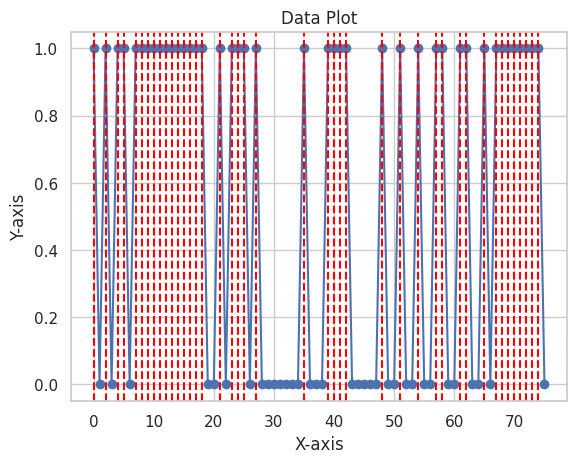

In [137]:
def binary_vis(y_test_):
    # Extract x and y values
    x_values, y_values = [i for i in range(len(y_test_))], y_test_.values

    # Plotting
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title('Data Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Add red vertical lines where y is 1
    for x, y in zip(x_values, y_values):
        if y == 1:
            plt.axvline(x, color='red', linestyle='--')

    plt.show()

## Experiments for updated version of the paper 

In [42]:
import pickle 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from scipy.stats import norm, laplace, logistic, gumbel_r, lognorm, cauchy, genextreme 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, ExtraTreeClassifier
from sksurv.ensemble import GradientBoostingSurvivalAnalysis



def train_survival_models(splitted_data, t_model, model):
    global scores_RandomSurvivalForest, results

    for name, values in splitted_data.items():
        X_train_survival = values['X_train_survival']
        y_train_survival = values['y_train_survival']

        if t_model not in ['SVM', 'Decision Tree', 'Linear Model']:
            est_cph_tree = model
            for i in range(5, 61, 5):
                n_estimators = i 
                est_cph_tree.set_params(n_estimators=n_estimators)
                est_cph_tree.fit(X_train_survival, y_train_survival)
                scores_RandomSurvivalForest['scores_cph_tree'+str(n_estimators)] = pickle.dumps(est_cph_tree)
        else:
            est_cph_tree = model
            est_cph_tree.fit(X_train_survival, y_train_survival)
            scores_RandomSurvivalForest['scores_cph_tree'] = pickle.dumps(est_cph_tree)

def evaluate_risk_prediction(splitted_data, t_model, threshold):
    #global scores_RandomSurvivalForest, results

    for name, values in splitted_data.items():
        X_test_survival = values['X_test_survival']
        y_test_survival = values['y_test_survival']
        X_train_survival = values['X_train_survival']
        y_test = values['y_test']
        y_train = values['y_train']

        #THRESHOLD = round(dataframes[name]['threshold'].iloc[0])
        THRESHOLD = np.quantile(y_train, threshold)
        y_test_ = (y_test > THRESHOLD).astype(int)
        y_train_ = (y_train > THRESHOLD).astype(int)

        if t_model not in ['SVM', 'Decision Tree', 'Linear Model']:

            for i in range(5, 61, 5):

                # Approach 1
                predicted_risks = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict(X_test_survival)
                for key, value in enumerate(y_test_):
                    if value == 1: 
                        guide_n = key
                        break
                guide = predicted_risks[guide_n]
                y_pred_binary = (predicted_risks > guide).astype(int)
                #metrics
                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)
                
                predictions['scores_cph_tree'+str(i)+'_risk-prediction-guide-on-test'] = y_pred_binary

                results.append([name, f'scores_cph_tree{i}_risk-prediction-guide-on-test', None, accuracy, precision, recall, f1, None, None])


                #Approach 2
                historical_predicted_risks = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict(X_train_survival)
                for key, value in enumerate(y_train_):
                    if value == 1: 
                        guide_n = key
                        break
                guide = historical_predicted_risks[guide_n]
                #transform the risks to binary outcome
                y_pred_binary = (predicted_risks >= guide).astype(int)

                #metrics
                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)

                predictions['scores_cph_tree'+str(i)+'_rrisk-prediction-guide-on-train'] = y_pred_binary

                results.append([name, f'scores_cph_tree{i}_risk-prediction-guide-on-train', None, accuracy, precision, recall, f1, None, None])


                #Approach 3
                y_pred_binary = []
                for key, value in enumerate(predicted_risks):
                    if value > guide:
                        y_pred_binary.append(1)
                    elif value < guide:
                        y_pred_binary.append(0)
                    else: 
                        y_pred_binary.append(1)

                #metrics
                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)

                predictions['scores_cph_tree'+str(i)+'_risk-prediction-guide-on-train-alt'] = y_pred_binary

                results.append([name, f'scores_cph_tree{i}_risk-prediction-guide-on-train-alt', None, accuracy, precision, recall, f1, None, None])

        else: 
            # Approach 1
            predicted_risks = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).predict(X_test_survival)
            for key, value in enumerate(y_test_):
                if value == 1: 
                    guide_n = key
                    break
            guide = predicted_risks[guide_n]
            y_pred_binary = (predicted_risks > guide).astype(int)
            #metrics
            accuracy = accuracy_score(y_test_, y_pred_binary)
            precision = precision_score(y_test_, y_pred_binary)
            recall = recall_score(y_test_, y_pred_binary)
            f1 = f1_score(y_test_, y_pred_binary)
            
            predictions['scores_cph_tree'+'_risk-prediction-guide-on-test'] = y_pred_binary

            results.append([name, 'scores_cph_tree_risk-prediction-guide-on-test', None, accuracy, precision, recall, f1, None, None])


            #Approach 2
            historical_predicted_risks = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).predict(X_train_survival)
            for key, value in enumerate(y_train_):
                if value == 1: 
                    guide_n = key
                    break
            guide = historical_predicted_risks[guide_n]
            #transform the risks to binary outcome
            y_pred_binary = (predicted_risks >= guide).astype(int)

            #metrics
            accuracy = accuracy_score(y_test_, y_pred_binary)
            precision = precision_score(y_test_, y_pred_binary)
            recall = recall_score(y_test_, y_pred_binary)
            f1 = f1_score(y_test_, y_pred_binary)

            predictions['scores_cph_tree'+'_rrisk-prediction-guide-on-train'] = y_pred_binary

            results.append([name, 'scores_cph_tree_risk-prediction-guide-on-train', None, accuracy, precision, recall, f1, None, None])


            #Approach 3
            y_pred_binary = []
            for key, value in enumerate(predicted_risks):
                if value > guide:
                    y_pred_binary.append(1)
                elif value < guide:
                    y_pred_binary.append(0)
                else: 
                    y_pred_binary.append(1)

            #metrics
            accuracy = accuracy_score(y_test_, y_pred_binary)
            precision = precision_score(y_test_, y_pred_binary)
            recall = recall_score(y_test_, y_pred_binary)
            f1 = f1_score(y_test_, y_pred_binary)

            predictions['scores_cph_tree'+'_risk-prediction-guide-on-train-alt'] = y_pred_binary

            results.append([name, 'scores_cph_tree_risk-prediction-guide-on-train-alt', None, accuracy, precision, recall, f1, None, None])


def evaluate_survival_prob(splitted_data, t_model, threshold):
    #global scores_RandomSurvivalForest, results

    for name, values in splitted_data.items():
        X_test_survival = values['X_test_survival']
        y_test_survival = values['y_test_survival']
        X_train_survival = values['X_train_survival']
        y_test = values['y_test']
        y_train = values['y_train']

        #THRESHOLD = round(dataframes[name]['threshold'].iloc[0])
        THRESHOLD = np.quantile(y_train, threshold)
        y_test_ = (y_test > THRESHOLD).astype(int)
        y_train_ = (y_train > THRESHOLD).astype(int)

        prob_percentages = [0.85, 0.90]

        if t_model not in ['Linear Model']:

            for i in range(5, 61, 5):

                ## Approach 1
                for prob_percentage in prob_percentages:
                    list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_test_survival, return_array=True)

                    y_pred_binary = pd.DataFrame(list_of_lists[0:,0], columns=['probabilities'])['probabilities'].apply(lambda x: 1 if x < prob_percentage else 0).values

                    # Calculate metrics
                    accuracy = accuracy_score(y_test_, y_pred_binary)
                    precision = precision_score(y_test_, y_pred_binary)
                    recall = recall_score(y_test_, y_pred_binary)
                    f1 = f1_score(y_test_, y_pred_binary)
                    roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])

                    predictions['scores_cph_tree'+str(i)+'_survival-prob'] = y_pred_binary
                    
                    results.append([name, f'scores_cph_tree'+str(i)+'_survival-prob', np.round(pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).score(X_test_survival, y_test_survival),2),accuracy, precision, recall, f1, roc_auc, None])
        

                ## Approach 2
                list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_test_survival, return_array=True)
                historical_list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_train_survival, return_array=True)

                #Use guide from real data 
                predicted_mean_survival_prob = []

                for prob in list_of_lists:
                    predicted_mean_survival_prob.append(np.mean(prob))

                #Use guide from historical data
                historical_predicted_mean_survival_prob = []

                for prob in historical_list_of_lists:
                    historical_predicted_mean_survival_prob.append(np.mean(prob))


                for key, value in enumerate(y_train_):
                    if value ==1: 
                        guide_k = key
                        break

                guide = historical_predicted_mean_survival_prob[guide_k]

                y_pred_binary = []

                for key, value in enumerate(predicted_mean_survival_prob):
                    if value > guide:
                        y_pred_binary.append(1)
                    elif value < guide:
                        y_pred_binary.append(0)
                    else: 
                        y_pred_binary.append(1)
                

                # Calculate metrics
                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)
                #roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])

                predictions['scores_cph_tree'+str(i)+'_mean-survival-prob-adjusted'] = y_pred_binary
                
                results.append([name, f'scores_cph_tree'+str(i)+'_mean-survival-prob-adjusted', np.round(pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).score(X_test_survival, y_test_survival),2),accuracy, precision, recall, f1, None, None])

            
                ## Approach 3
                list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_test_survival, return_array=True)

                predicted_mean_survival_prob = []

                for prob in list_of_lists:
                    predicted_mean_survival_prob.append(np.mean(prob))

                y_pred_binary = []
                y_pred_binary = (np.array(predicted_mean_survival_prob) < 0.5).astype(int)


                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)
                roc_auc = roc_auc_score(y_test_, predicted_mean_survival_prob)

                predictions['scores_cph_tree'+str(i)+'_mean-survival-prob'] = y_pred_binary
                
                results.append([name, f'scores_cph_tree'+str(i)+'_mean-survival-prob', np.round(pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).score(X_test_survival, y_test_survival),2),accuracy, precision, recall, f1, roc_auc, None])

        else:

            ## Approach 1
            for prob_percentage in prob_percentages:
                list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).predict_survival_function(X_test_survival, return_array=True)

                y_pred_binary = pd.DataFrame(list_of_lists[0:,0], columns=['probabilities'])['probabilities'].apply(lambda x: 1 if x < prob_percentage else 0).values

                # Calculate metrics
                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)
                roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])

                predictions['scores_cph_tree'+'_survival-prob'] = y_pred_binary
                
                results.append([name, f'scores_cph_tree'+'_survival-prob', np.round(pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).score(X_test_survival, y_test_survival),2),accuracy, precision, recall, f1, roc_auc, None])
    

            ## Approach 2
            list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).predict_survival_function(X_test_survival, return_array=True)
            historical_list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).predict_survival_function(X_train_survival, return_array=True)

            #Use guide from real data 
            predicted_mean_survival_prob = []

            for prob in list_of_lists:
                predicted_mean_survival_prob.append(np.mean(prob))

            #Use guide from historical data
            historical_predicted_mean_survival_prob = []

            for prob in historical_list_of_lists:
                historical_predicted_mean_survival_prob.append(np.mean(prob))


            for key, value in enumerate(y_train_):
                if value ==1: 
                    guide_k = key
                    break

            guide = historical_predicted_mean_survival_prob[guide_k]

            y_pred_binary = []

            for key, value in enumerate(predicted_mean_survival_prob):
                if value > guide:
                    y_pred_binary.append(1)
                elif value < guide:
                    y_pred_binary.append(0)
                else: 
                    y_pred_binary.append(1)
            

            # Calculate metrics
            accuracy = accuracy_score(y_test_, y_pred_binary)
            precision = precision_score(y_test_, y_pred_binary)
            recall = recall_score(y_test_, y_pred_binary)
            f1 = f1_score(y_test_, y_pred_binary)
            #roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])

            predictions['scores_cph_tree'+'_mean-survival-prob-adjusted'] = y_pred_binary
            
            results.append([name, f'scores_cph_tree'+'_mean-survival-prob-adjusted', np.round(pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).score(X_test_survival, y_test_survival),2),accuracy, precision, recall, f1, None, None])

        
            ## Approach 3
            list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).predict_survival_function(X_test_survival, return_array=True)

            predicted_mean_survival_prob = []

            for prob in list_of_lists:
                predicted_mean_survival_prob.append(np.mean(prob))

            y_pred_binary = []
            y_pred_binary = (np.array(predicted_mean_survival_prob) < 0.5).astype(int)


            accuracy = accuracy_score(y_test_, y_pred_binary)
            precision = precision_score(y_test_, y_pred_binary)
            recall = recall_score(y_test_, y_pred_binary)
            f1 = f1_score(y_test_, y_pred_binary)
            roc_auc = roc_auc_score(y_test_, predicted_mean_survival_prob)

            predictions['scores_cph_tree'+'_mean-survival-prob'] = y_pred_binary
            
            results.append([name, f'scores_cph_tree'+'_mean-survival-prob', np.round(pickle.loads(scores_RandomSurvivalForest['scores_cph_tree']).score(X_test_survival, y_test_survival),2),accuracy, precision, recall, f1, roc_auc, None])

def evaluate_regression_approach(splitted_data, threshold, model):
    # global results

    distributions = [genextreme, norm, laplace, logistic, gumbel_r, lognorm, cauchy]

    for name, values in splitted_data.items():
        X_test = values['X_test']
        y_test = values['y_test']
        y_train = values['y_train']
        X_train = values['X_train']

        #THRESHOLD = round(dataframes[name]['threshold'].iloc[0])
        THRESHOLD = np.quantile(y_train, threshold)
        y_test_ = (y_test > THRESHOLD).astype(int)

        regression = model
        for distribution in distributions:
            regression.fit(X_train, y_train)

            point_forecasts = regression.predict(X_test)
            std = y_train.std()
            if distribution == lognorm:
                exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, s=std) for x_ in point_forecasts])
            elif distribution == genextreme:
                exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, c=-0.1, loc=x_, scale=std) for x_ in point_forecasts])
            elif distribution != lognorm:
                exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, scale=std) for x_ in point_forecasts])

            y_pred_binary = np.where(exceedance_prob >= 0.5, 1, 0)

            accuracy = accuracy_score(y_test_, y_pred_binary)
            precision = precision_score(y_test_, y_pred_binary)
            recall = recall_score(y_test_, y_pred_binary)
            f1 = f1_score(y_test_, y_pred_binary)
            roc_auc = roc_auc_score(y_test_, exceedance_prob)

            results.append([name, '_Cerceira', None, accuracy, precision, recall, f1, None, distribution])

def evaluate_binary_classification(splitted_data, threshold, model):
    # global results

    for name, values in splitted_data.items():
        X_test = values['X_test']
        y_test = values['y_test']
        y_train = values['y_train']
        X_train = values['X_train']
        THRESHOLD = np.quantile(y_train, threshold)
        y_test_binary = (y_test > THRESHOLD).astype(int)
        y_train_binary = (y_train > THRESHOLD).astype(int)

        rf_classifier = model
        rf_classifier.fit(X_train, y_train_binary)

        y_pred = rf_classifier.predict(X_test)

        accuracy = accuracy_score(y_test_binary, y_pred)
        precision = precision_score(y_test_binary, y_pred)
        recall = recall_score(y_test_binary, y_pred)
        f1 = f1_score(y_test_binary, y_pred)

        results.append([name, '_BinaryCLF', None, accuracy, precision, recall, f1, None, None])



In [35]:
random_state = 42

available_models = {'Decision Tree':{'survival_model':SurvivalTree(), 
                                         'regression_model': DecisionTreeRegressor(random_state=random_state), 
                                         'classification_model': DecisionTreeClassifier(random_state=random_state)},

                    'Random Forest':{'survival_model':RandomSurvivalForest(random_state=random_state), 
                                         'regression_model': RandomForestRegressor(random_state=random_state), 
                                         'classification_model': RandomForestClassifier(random_state=random_state)},

                    'Gradient Boosting':{'survival_model':GradientBoostingSurvivalAnalysis(random_state=random_state), 
                                         'regression_model': GradientBoostingRegressor(random_state=random_state), 
                                         'classification_model': GradientBoostingClassifier(random_state=random_state)},

                    'Extra Trees':{'survival_model':ExtraSurvivalTrees(random_state=random_state), 
                                         'regression_model': ExtraTreesRegressor(random_state=random_state), 
                                         'classification_model': ExtraTreeClassifier(random_state=random_state)}, 

                    'Linear Model':{'survival_model':CoxPHSurvivalAnalysis(), 
                                         'regression_model': LinearRegression(), 
                                         'classification_model': LogisticRegression(random_state=random_state)}, 

                    'SVM':{'survival_model':NaiveSurvivalSVM(random_state=random_state), 
                                         'regression_model': SVR(), 
                                         'classification_model': SVC(random_state=random_state)}}

In [43]:
random_state = 42
scores_RandomSurvivalForest = {}
results = []
predictions = {}

type_of_model = 'Linear Model' 

def execute_all_functions(threshold, type_of_model=type_of_model):
    train_survival_models(splitted_data, t_model = type_of_model, model=available_models[type_of_model]['survival_model'])
    evaluate_risk_prediction(splitted_data, t_model = type_of_model, threshold=threshold)
    if type_of_model not in ['SVM', 'Decision Tree']:
        evaluate_survival_prob(splitted_data, t_model=type_of_model, threshold=threshold)
    evaluate_regression_approach(splitted_data, threshold, model=available_models[type_of_model]['regression_model'])
    evaluate_binary_classification(splitted_data, threshold, model=available_models[type_of_model]['classification_model'])

# Call the function to execute all functions
execute_all_functions(threshold=0.85)

#### Save, Read and Visualize the output results

In [44]:
name = 'new_approach_v0.74_decision_tree_agroknow_not_historical'

In [45]:
import io 
from tabulate import tabulate


get_results_df(df_name=name, results=results)

In [46]:
# Read Data 
import pandas as pd


new_results = read_csv(name=name)

new_results = get_data_ready_for_vis(new_results)

groups_of_runs = group_values_by_pattern(df=new_results, column_name='Algorithm')

algorithm_name = create_name_for_vis(name)

# Apply the function to assign categories to the 'algorithm' column
new_results['Category'] = new_results['Algorithm'].apply(assign_category)

print(new_results['Category'].unique())

TimeSerie        object
Algorithm        object
c-index          object
accuracy        float64
precision       float64
recall          float64
f1              float64
Roc-Auc          object
Distribution     object
dtype: object
['risk-prediction-guide-on-test' 'risk-prediction-guide-on-train'
 'risk-prediction-guide-on-train-alt' 'survival-prob'
 'mean-survival-prob-adjusted' 'mean-survival-prob' 'Cerceira' 'BinaryCLF']


In [47]:
new_results.columns

Index(['TimeSerie', 'Algorithm', 'c-index', 'accuracy', 'precision', 'recall',
       'f1', 'Roc-Auc', 'Distribution', 'Category'],
      dtype='object')

In [48]:
new_results['Category'].unique()

array(['risk-prediction-guide-on-test', 'risk-prediction-guide-on-train',
       'risk-prediction-guide-on-train-alt', 'survival-prob',
       'mean-survival-prob-adjusted', 'mean-survival-prob', 'Cerceira',
       'BinaryCLF'], dtype=object)

In [49]:
# Drop rows where the 'Category' column is 'survival-prob'
new_results_ = new_results[new_results['Category'] != 'risk-prediction-guide-on-test']

In [50]:
new_results_ = new_results_[new_results_['Category']!='survival-prob']
new_results_ = new_results_[new_results_['Category']!='risk-prediction-guide-on-train-alt']


In [51]:
new_results_ = new_results_[new_results_['Category']!='mean-survival-prob-adjusted']

In [52]:
new_results_['Category'].unique()

array(['risk-prediction-guide-on-train', 'mean-survival-prob', 'Cerceira',
       'BinaryCLF'], dtype=object)

In [53]:
# Assuming `new_results` is your DataFrame and you want to change 'Old_Category_Name' to 'New_Category_Name'
new_results_['Category'] = new_results_['Category'].replace('risk-prediction-guide-on-train', 'risk_prediction')

In [54]:
new_results_['Category'].unique()

array(['risk_prediction', 'mean-survival-prob', 'Cerceira', 'BinaryCLF'],
      dtype=object)

##### Plots

In [73]:
metrics = ['accuracy','precision', 'recall', 'f1']
path = '/home/gmarinos/Documents/Code/extended_version_1st_pub/plots'
desired_order = {'desired_order_1':['risk_prediction', 'mean-survival-prob', 'Cerceira', 'BinaryCLF'], 
                 'desired_order_2':['risk_prediction', 'Cerceira', 'BinaryCLF']}

In [76]:
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 



def create_boxplot(metrics, path, type_of_model):

    # Select relevant columns for boxplots
    selected_df = new_results_[['Category'] + metrics]

    # Melt the DataFrame to long format for seaborn
    melted_df = pd.melt(selected_df, id_vars=['Category'], value_vars=metrics, var_name='Metric', value_name='Value')

    # Extract unique categories from the dictionary
    # categories = list(groups_of_runs.keys())
    # palette_colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightyellow', 'lightgrey', 'lightpink', 'lightcyan']
    # # Slice the palette_colors list to match the length of categories
    # palette_colors = palette_colors[:len(categories)]
    # # Generate a color palette with unique colors for each category
    # palette = {category: color for category, color in zip(categories, palette_colors)}

    # Set up the plot
    plt.figure(figsize=(16, 10))
    sns.set_theme(style="whitegrid")

    # Create boxplot using seaborn with unique colors
    ax = sns.boxplot(x='Metric', y='Value', hue='Category', data=melted_df, palette='pastel6')

    # Rotate x-axis labels vertically
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add labels and title
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title(type_of_model)

    # Adjust the legend position
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    file_path = os.path.join(path, algorithm_name+str('.png'))
    plt.savefig(file_path)
    plt.show()


In [77]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def create_barchart(metrics, desired_order, path, type_of_model):

    # Select relevant columns for boxplots
    selected_df = new_results_[['Category'] + metrics]

    # Calculate mean values for each metric
    mean_values = selected_df.groupby('Category').mean().reset_index()

    # Define the desired order of categories
    if type_of_model not in ['SVM', 'Decision Tree']:   
        desired_order = desired_order['desired_order_1']
    else:
        desired_order = desired_order['desired_order_2']
    # Reindex the DataFrame based on the desired order of categories
    mean_values = mean_values.set_index('Category').reindex(desired_order).reset_index()

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    # sns.color_palette('colorblind6')

    # Plot bar charts for each metric
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        sns.barplot(x='Category', y=metric, data=mean_values, palette='pastel6')
        plt.title(metric.capitalize())
        plt.xlabel('')
        plt.ylabel('Mean ' + metric.capitalize())
        plt.xticks(rotation=45, fontsize='small')  # Rotate x-axis labels

    # Adjust layout
    plt.tight_layout()

    # Add overall title
    plt.suptitle(type_of_model, y=1.05)

    # Save the plot
    file_path = os.path.join(path, algorithm_name + '_mean_values_without_line.png')
    plt.savefig(file_path)

    # Show the plot
    plt.show()


In [78]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



def create_barchart_with_line(metrics, desired_order, path, type_of_model):
    selected_df = new_results_[['Category'] + metrics]

    # Calculate mean values for each metric
    mean_values = selected_df.groupby('Category').mean().reset_index()

    # Define the desired order of categories
    if type_of_model not in ['SVM', 'Decision Tree']:   
        desired_order = desired_order['desired_order_1']
    else:
        desired_order = desired_order['desired_order_2']
    # Reindex the DataFrame based on the desired order of categories
    mean_values = mean_values.set_index('Category').reindex(desired_order).reset_index()

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # Plot bar charts for each metric
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        ax = sns.barplot(x='Category', y=metric, data=mean_values, palette='pastel6')
        plt.title(metric.capitalize())
        plt.xlabel('')
        plt.ylabel('Mean ' + metric.capitalize())
        plt.xticks(rotation=30, fontsize='small')  # Rotate x-axis labels and set font size to small
        
        # Add lines connecting the middle upper part of each bar
        for bar, category in zip(ax.patches, mean_values['Category']):
            category_index = mean_values['Category'].tolist().index(category)
            if category_index < len(mean_values) - 1:
                next_bar = ax.patches[category_index + 1]
                x1 = bar.get_x() + bar.get_width() / 2
                y1 = bar.get_height()
                x2 = next_bar.get_x() + next_bar.get_width() / 2
                y2 = next_bar.get_height()
                plt.plot([x1, x2], [y1, y2], color='gray')

    # Adjust layout
    plt.tight_layout()

    # Add overall title
    plt.suptitle(type_of_model, y=1.05)

    # Save the plot
    file_path = os.path.join(path, algorithm_name + '_mean_values_with_lines.png')
    plt.savefig(file_path)

    # Show the plot
    plt.show()



In [74]:

def mean_values_barcharts(metrics, path):

    selected_df = new_results_[['Category'] + metrics]

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")

    # Melt the DataFrame to long format for seaborn
    melted_df = selected_df.melt(id_vars='Category', var_name='Metric', value_name='Value')

    # Plot bar chart
    ax = sns.barplot(data=melted_df, x='Metric', y='Value', hue='Category', palette='pastel6')

    # Rotate x-axis labels and set font size
    plt.xticks(rotation=45, fontsize='small')

    # Add legend
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add labels and title
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title(type_of_model)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    file_path = os.path.join(path, algorithm_name + '_mean_values.png')
    plt.savefig(file_path)

    # Show the plot
    plt.show()




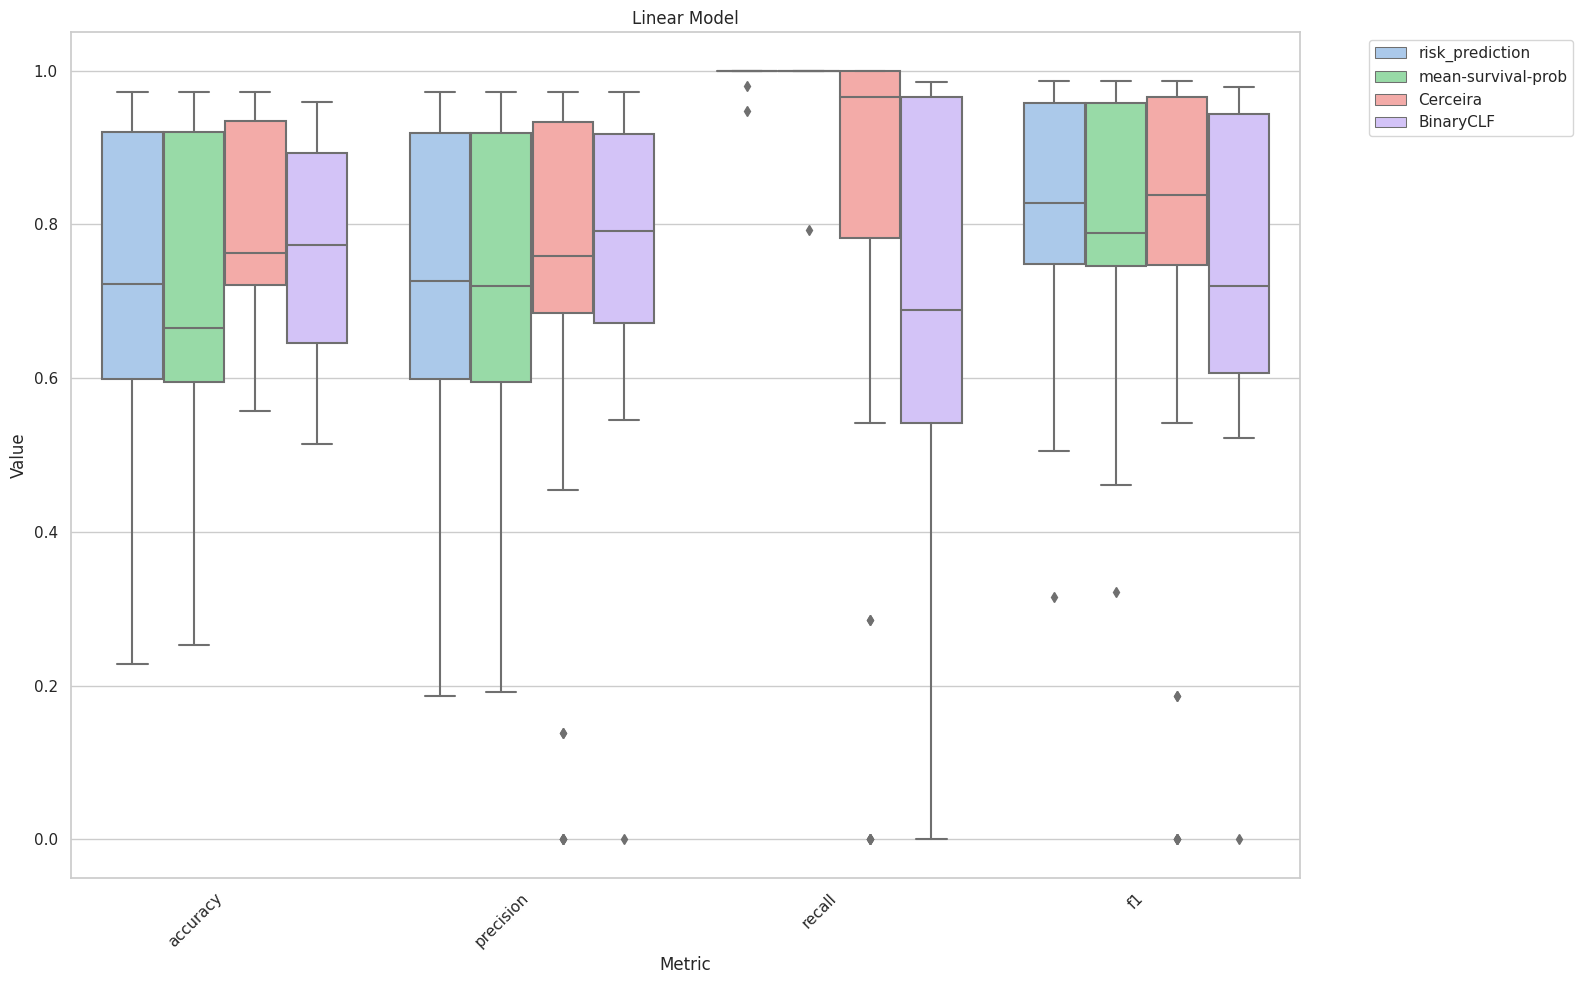

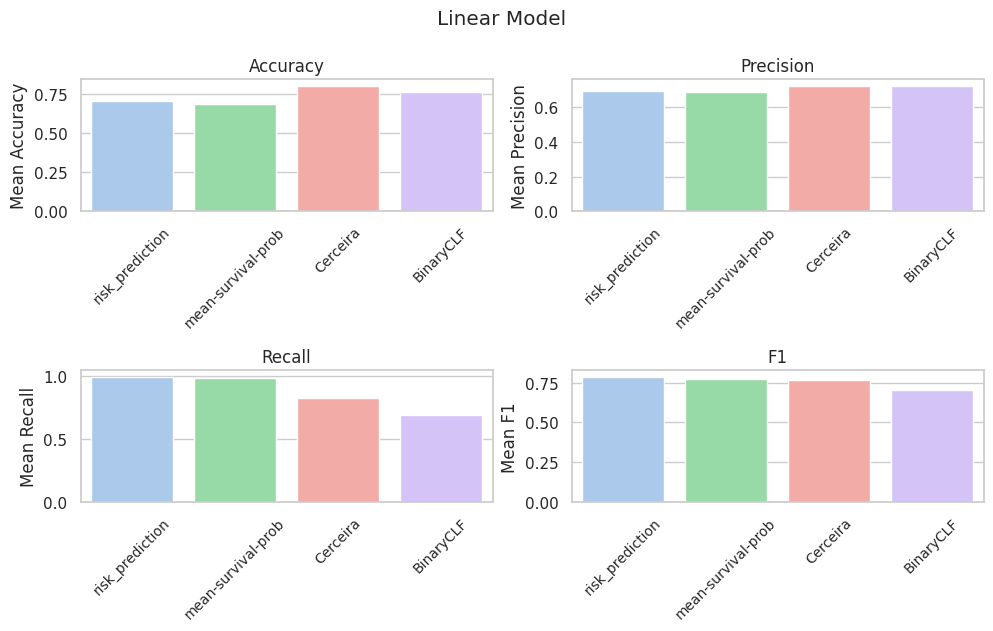

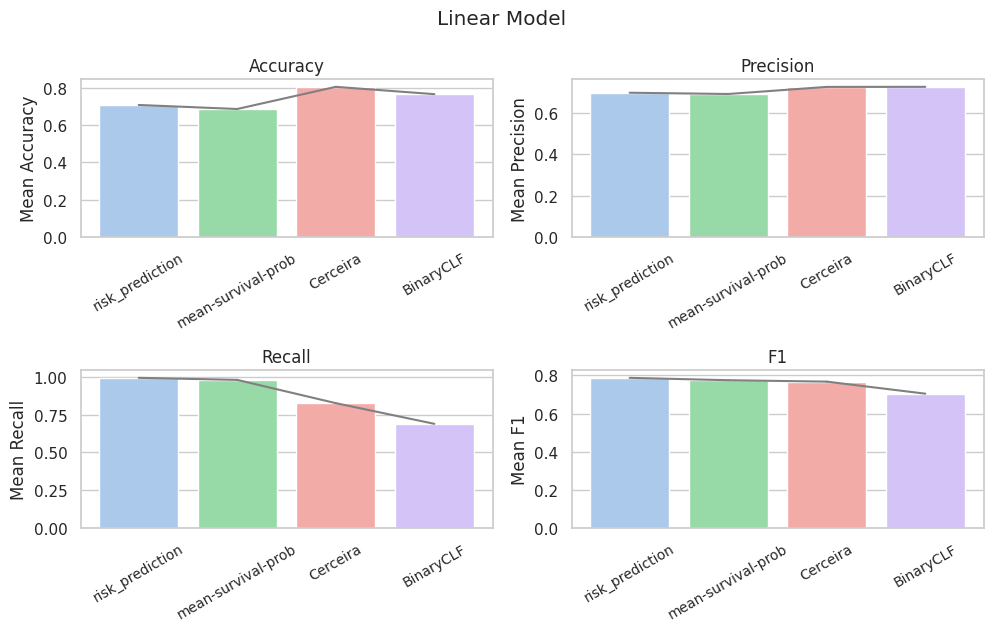

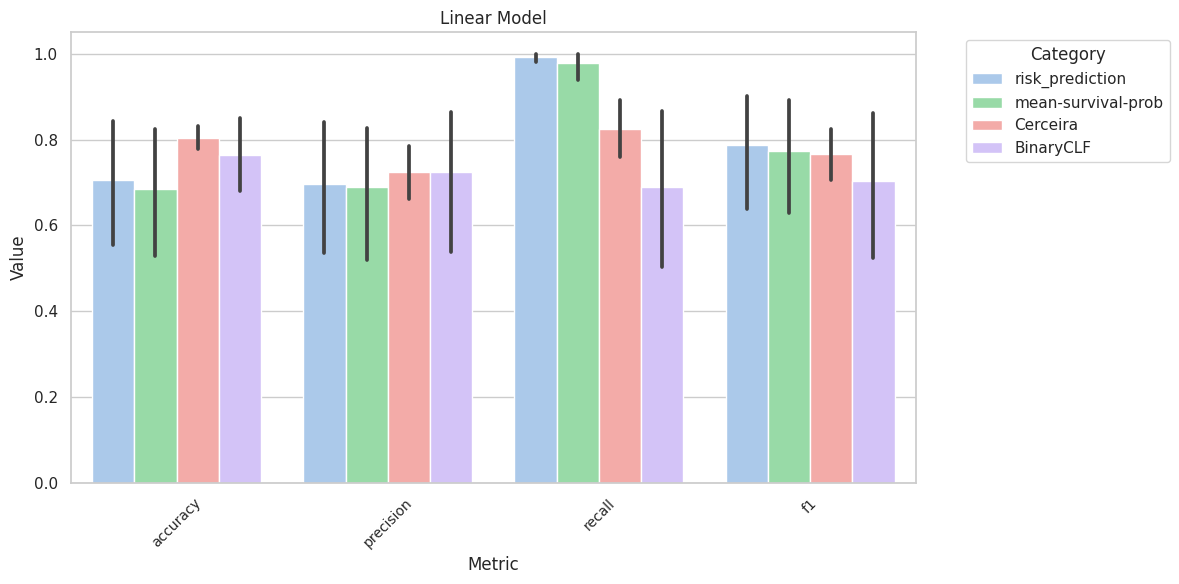

In [79]:
create_boxplot(metrics, path, type_of_model)
create_barchart(metrics, desired_order, path, type_of_model)
create_barchart_with_line(metrics, desired_order, path, type_of_model)
mean_values_barcharts(metrics, path)

In [72]:
predictions

{'scores_cph_tree_risk-prediction-guide-on-test': array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 'scores_cph_tree_rrisk-prediction-guide-on-train': array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'scores_cph_tree_risk-prediction-guide-on-train-alt': [1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  

##### External Dataset

##### Global temperature time series 

###### link for the data below -> https://datahub.io/core/global-temp?ref=hackernoon.com

In [113]:
pd.read_csv('/home/gmarinos/Downloads/monthly.csv')['Source'].unique()

array(['GCAG', 'GISTEMP'], dtype=object)

In [114]:
data = pd.read_csv('/home/gmarinos/Downloads/monthly.csv')

data_GCAG = data[data['Source']=='GCAG']

data_GISTEMP = data[data['Source']=='GISTEMP']

<AxesSubplot:>

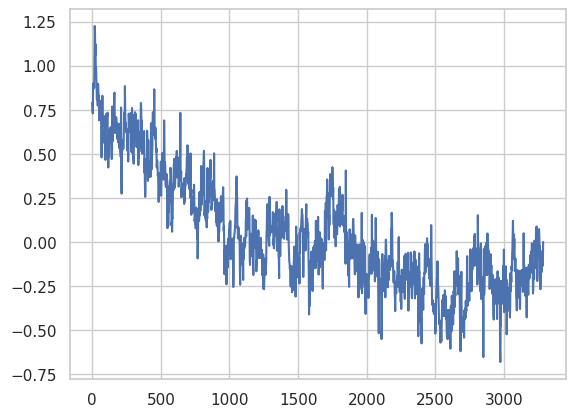

In [117]:
data_GCAG['Mean'].plot()

<AxesSubplot:>

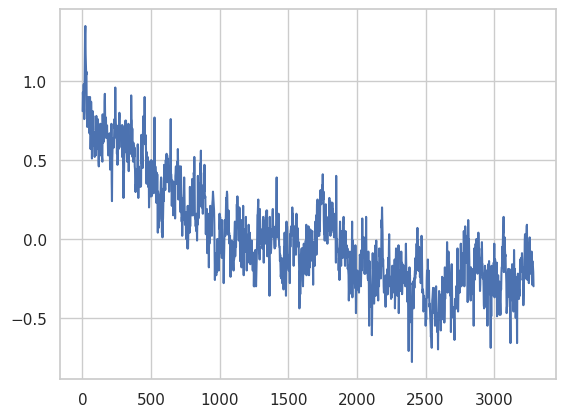

In [118]:
data_GISTEMP['Mean'].plot()

In [119]:
print(data_GISTEMP.shape, data_GCAG.shape)

(1644, 3) (1644, 3)


##### Web traffic dataset

###### link here -> https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/data?select=train_1.csv.zip

In [153]:
import pandas as pd 

web_traffic = pd.read_csv('/home/gmarinos/Downloads/train_1.csv')

# Initialize an empty dictionary to store results
first_10_rows_dict = {}

# Iterate through the first 10 rows and construct the dictionary
for i, (_, row)  in enumerate(pd.DataFrame(web_traffic).head(13).iterrows()):
    # Construct key based on the index
    key = f'web_site_{i+1}'
    # Add key-value pair to the dictionary
    first_10_rows_dict[key] = row

In [154]:
def data_preprocess():

    for key, value in first_10_rows_dict.items():

        row = pd.DataFrame(value.values,index=value.index, columns=['Incidents'])

        row = row.iloc[1:]

        first_10_rows_dict[key] = row

        row = row.reset_index()

        row.rename(columns={'index':'Date'}, inplace=True)

        print(row.isna().sum().sum())

        row.fillna(0, inplace=True)

        row['Incidents'] = row['Incidents'].astype(int)
        
        row['Date'] = pd.to_datetime(row['Date'])

        row.set_index('Date')

        # Define the threshold for extreme events
        threshold = row['Incidents'].quantile(0.85)

        # New column to remind us the threshold 
        row['threshold'] = threshold

        row['extreme_event'] = (row['Incidents'] > threshold).astype(int)

        first_10_rows_dict[key] = row

    return first_10_rows_dict


In [155]:
first_10_rows_dict = data_preprocess()

0
0
0
0
291
0
365
0
0
0
31
0
0


In [156]:
# List of keys to delete
keys_to_delete = ['web_site_5', 'web_site_7', 'web_site_11']

# Delete keys and their corresponding values
for key in keys_to_delete:
    if key in first_10_rows_dict:
        del first_10_rows_dict[key]


In [157]:
for key, value in first_10_rows_dict.items():
    print(value.isna().sum().sum())

0
0
0
0
0
0
0
0
0
0


[]

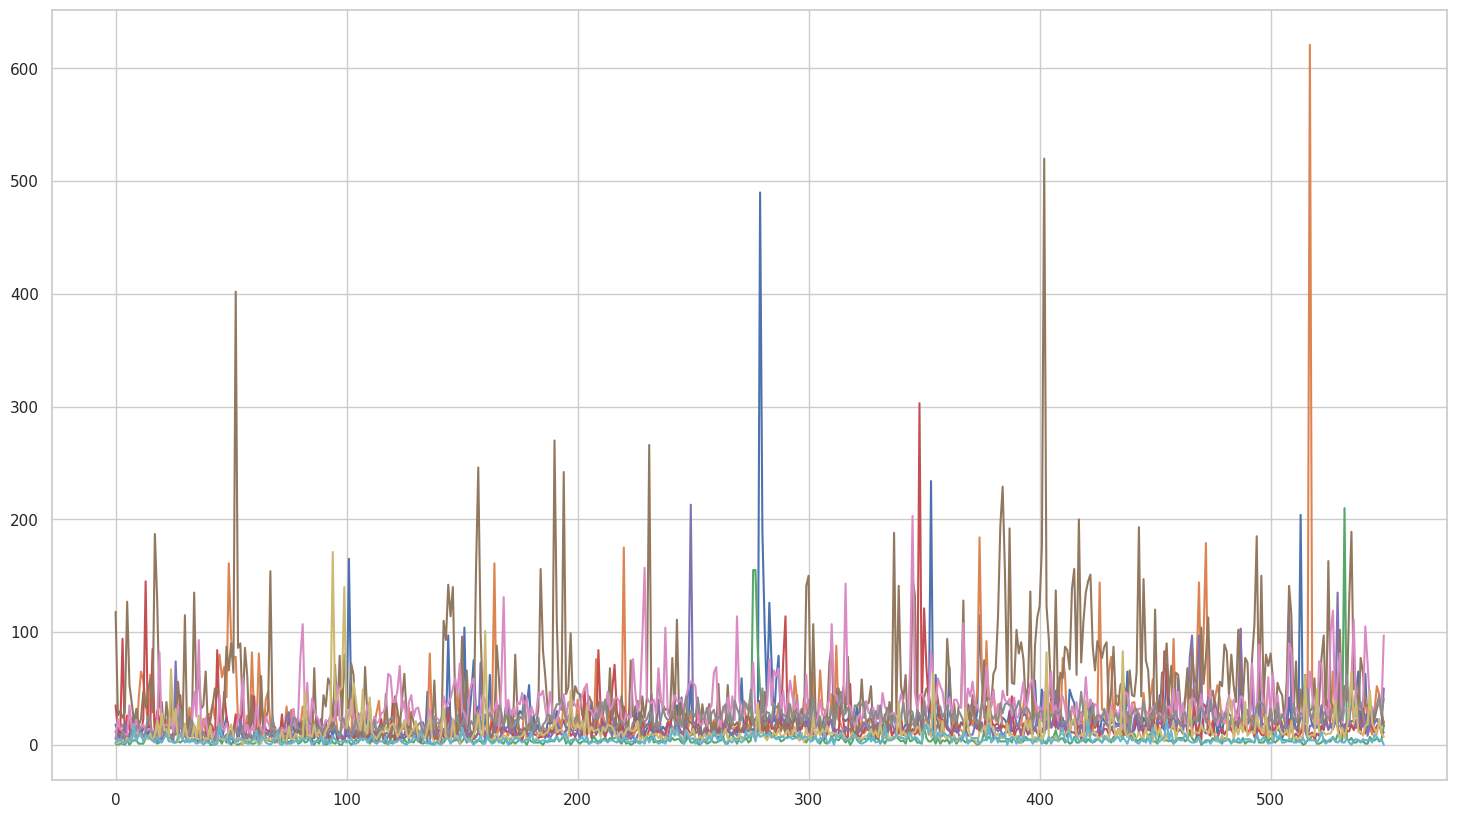

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))

for key, value in first_10_rows_dict.items():

    value['Incidents'].plot()

plt.plot()

In [158]:
# config
timesteps = 10 
test_size = 0.2 



# Usage example
dataframes = process_dataframes(dataset=first_10_rows_dict, quantile=0.85)
survival_analysis_ready_data  = create_survival_analysis_ready_data(datasets=dataframes, timesteps=timesteps)
splitted_data = create_splitted_data(survival_data=survival_analysis_ready_data, test_size=test_size)

            Incidents  extreme_event
Date                                
2015-07-01         18              0
2015-07-02         11              0
2015-07-03          5              0
2015-07-04         13              0
2015-07-05         14              0
...               ...            ...
2016-12-27         20              0
2016-12-28         22              0
2016-12-29         19              0
2016-12-30         18              0
2016-12-31         20              0

[550 rows x 2 columns]
2015-07-01 00:00:00
2015-07-01 00:00:00
<class 'NoneType'>
            Incidents  extreme_event
Date                                
2015-07-01         11              0
2015-07-02         14              0
2015-07-03         15              0
2015-07-04         18              0
2015-07-05         11              0
...               ...            ...
2016-12-27         30              0
2016-12-28         52              1
2016-12-29         45              1
2016-12-30         26        


*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [186]:
check_percentage_of_nan_in_surv_ready_data(survival_analysis_ready_data)

for web_site_1 zeros are: 459 in 540 so the percentage is: 85.0 %
for web_site_2 zeros are: 459 in 540 so the percentage is: 85.0 %
for web_site_3 zeros are: 486 in 540 so the percentage is: 90.0 %
for web_site_4 zeros are: 461 in 540 so the percentage is: 85.37 %
for web_site_6 zeros are: 464 in 540 so the percentage is: 85.93 %
for web_site_8 zeros are: 462 in 540 so the percentage is: 85.56 %
for web_site_9 zeros are: 458 in 540 so the percentage is: 84.81 %
for web_site_10 zeros are: 465 in 540 so the percentage is: 86.11 %
for web_site_12 zeros are: 457 in 540 so the percentage is: 84.63 %
for web_site_13 zeros are: 481 in 540 so the percentage is: 89.07 %


##### Numenta anomaly benchmark dataset

###### link here -> https://github.com/numenta/NAB/tree/master